# Exploratory Data Analysis: Gold Commodity News

This notebook performs a comprehensive exploratory data analysis of the gold commodify news dataset, which we'll be using for the sentiment analysis task in our LLM distillation thesis.

Dataset: https://www.kaggle.com/datasets/daittan/gold-commodity-news-and-dimensions/data

Paper: https://arxiv.org/abs/2009.04202

### Setup and Imports

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from transformers import AutoTokenizer
from IPython.display import display

# Set up plot aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (12, 8)

# move one directory up to import modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from src.prompts.gold import get_gold_classification_prompt
from src.data.data_manager import GoldDataManager

### Loading dataset

In [17]:
df = pd.read_csv('../data/gold_dataset.csv')

### Dataset Overview

In [18]:
# Print basic dataset information
print(f"Dataset Shape: {df.shape}")
print("\nDataset Sample:")
display(df.head())

# Check for missing values
print("\nMissing Values:")
display(df.isnull().sum())

Dataset Shape: (11412, 12)

Dataset Sample:


,Dates,URL,News,Price or Not,Direction Up,Direction Constant,Direction Down,PastPrice,FuturePrice,PastNews,FutureNews,Asset Comparision
0,2016-01-28,http://www.marketwatch.com/story/april-gold-do...,"april gold down 20 cents to settle at $1,116.1...",1,0,0,1,1,0,0,0,0
1,2017-09-13,http://www.marketwatch.com/story/gold-prices-s...,gold suffers third straight daily decline,1,0,0,1,1,0,0,0,0
2,2016-07-26,http://www.marketwatch.com/story/gold-futures-...,Gold futures edge up after two-session decline,1,1,0,0,1,0,0,0,0
3,2018-02-28,https://www.metalsdaily.com/link/277199/dent-r...,dent research : is gold’s day in the sun comin...,0,0,0,0,0,0,0,1,0
4,2017-09-06,http://www.marketwatch.com/story/gold-steadies...,"Gold snaps three-day rally as Trump, lawmakers...",1,1,0,0,1,0,0,0,0



Missing Values:


Dates                 0
URL                   0
News                  0
Price or Not          0
Direction Up          0
Direction Constant    0
Direction Down        0
PastPrice             0
FuturePrice           0
PastNews              0
FutureNews            0
Asset Comparision     0
dtype: int64

### Class Distribution

In [19]:
# Print basic dataset information
print(f"Dataset Shape: {df.shape}")
print("\nDataset Sample:")
display(df.head())

# Check for missing values
print("\nMissing Values:")
display(df.isnull().sum())

# Check column data types
print("\nColumn Data Types:")
display(df.dtypes)

# Rename columns for easier handling (optional)
column_renames = {
    'Price or Not': 'price_or_not',
    'Direction Up': 'price_up',
    'Direction Constant': 'price_const_stable',
    'Direction Down': 'price_down',
    'PastPrice': 'past_price_info',
    'FuturePrice': 'future_price_info',
    'PastNews': 'past_gen_info',
    'FutureNews': 'future_gen_info',
    'Asset Comparision': 'asset_comparison'
}

# Check if columns need renaming (if they haven't been renamed already)
if 'Price or Not' in df.columns:
    df = df.rename(columns=column_renames)

# Define label columns (excluding metadata)
label_columns = [col for col in df.columns if col not in ['Dates', 'URL', 'News']]

# Print basic statistics for label columns
print("\nLabel Distribution:")
display(df[label_columns].describe())

Dataset Shape: (11412, 12)

Dataset Sample:


,Dates,URL,News,Price or Not,Direction Up,Direction Constant,Direction Down,PastPrice,FuturePrice,PastNews,FutureNews,Asset Comparision
0,2016-01-28,http://www.marketwatch.com/story/april-gold-do...,"april gold down 20 cents to settle at $1,116.1...",1,0,0,1,1,0,0,0,0
1,2017-09-13,http://www.marketwatch.com/story/gold-prices-s...,gold suffers third straight daily decline,1,0,0,1,1,0,0,0,0
2,2016-07-26,http://www.marketwatch.com/story/gold-futures-...,Gold futures edge up after two-session decline,1,1,0,0,1,0,0,0,0
3,2018-02-28,https://www.metalsdaily.com/link/277199/dent-r...,dent research : is gold’s day in the sun comin...,0,0,0,0,0,0,0,1,0
4,2017-09-06,http://www.marketwatch.com/story/gold-steadies...,"Gold snaps three-day rally as Trump, lawmakers...",1,1,0,0,1,0,0,0,0



Missing Values:


Dates                 0
URL                   0
News                  0
Price or Not          0
Direction Up          0
Direction Constant    0
Direction Down        0
PastPrice             0
FuturePrice           0
PastNews              0
FutureNews            0
Asset Comparision     0
dtype: int64


Column Data Types:


Dates                 object
URL                   object
News                  object
Price or Not           int64
Direction Up           int64
Direction Constant     int64
Direction Down         int64
PastPrice              int64
FuturePrice            int64
PastNews               int64
FutureNews             int64
Asset Comparision      int64
dtype: object


Label Distribution:


,price_or_not,price_up,price_const_stable,price_down,past_price_info,future_price_info,past_gen_info,future_gen_info,asset_comparison
count,11412.000000,11412.000000,11412.000000,11412.000000,11412.000000,11412.000000,11412.000000,11412.000000,11412.000000
mean,0.853049,0.415966,0.045829,0.370662,0.819751,0.033386,0.140028,0.007185,0.188398
std,0.354072,0.492909,0.209123,0.483003,0.384411,0.179650,0.347031,0.084465,0.391047
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Label Distributions

Label Distribution:


,Label,Count of 1s,Percentage
0,price_or_not,9735,85.304942
4,past_price_info,9355,81.975114
1,price_up,4747,41.596565
3,price_down,4230,37.066246
8,asset_comparison,2150,18.839818
6,past_gen_info,1598,14.002804
2,price_const_stable,523,4.582895
5,future_price_info,381,3.338591
7,future_gen_info,82,0.718542


/var/folders/4v/mg6gp3rx0yj803ddxqcd01bc0000gn/T/ipykernel_68896/2695108791.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Label', y='Count of 1s', data=label_counts.sort_values('Count of 1s', ascending=False), palette='viridis')


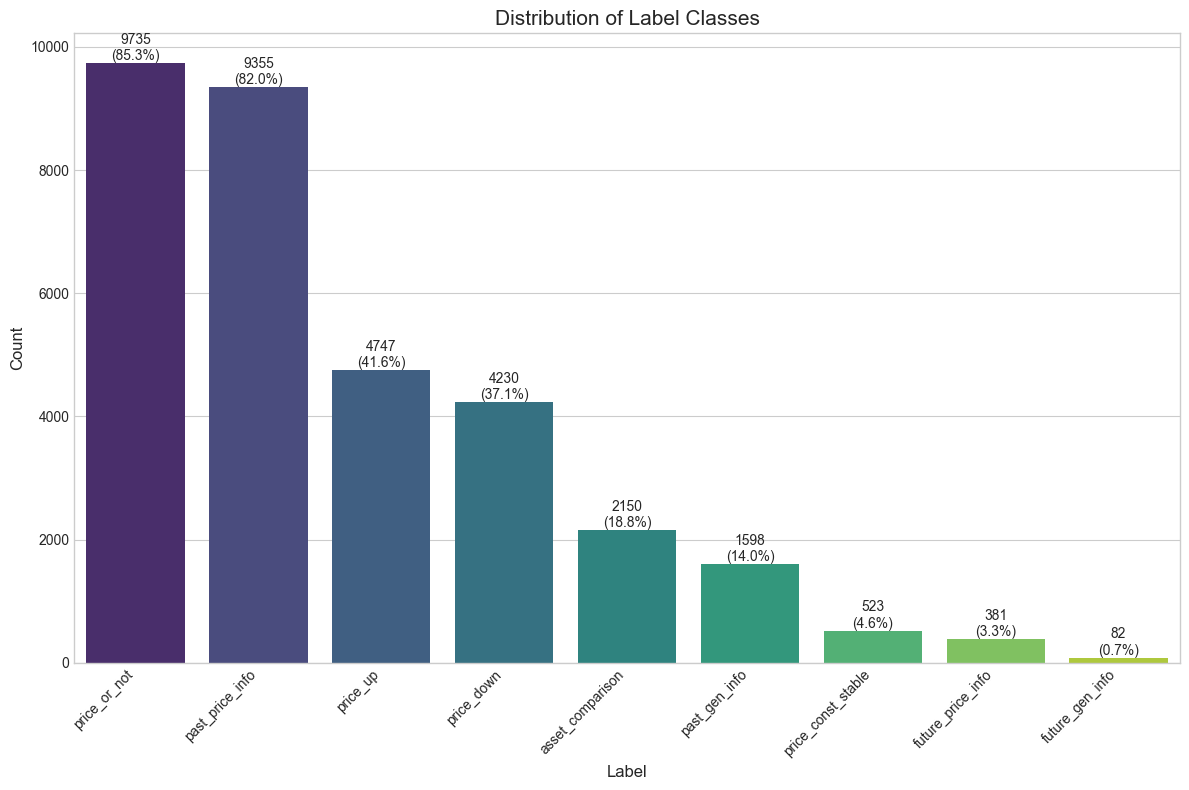

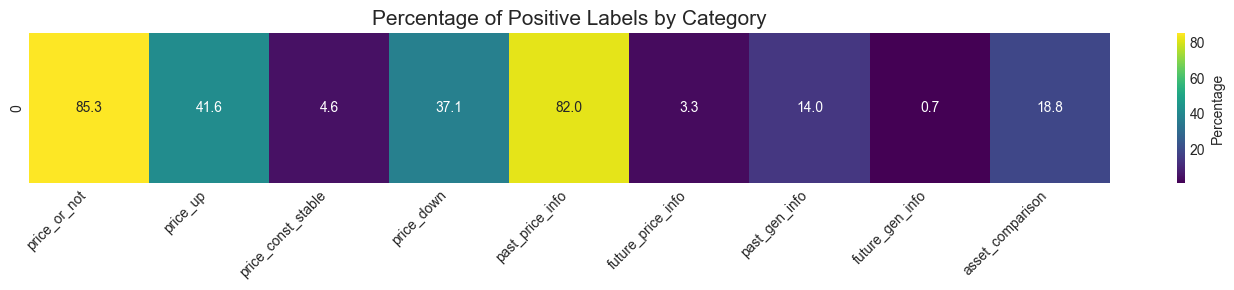

In [20]:
label_counts = pd.DataFrame({
    'Label': label_columns,
    'Count of 1s': [df[col].sum() for col in label_columns],
    'Percentage': [df[col].mean() * 100 for col in label_columns]
})

# Display table of label distribution
print("Label Distribution:")
display(label_counts.sort_values('Count of 1s', ascending=False))

# Plot the distribution
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Label', y='Count of 1s', data=label_counts.sort_values('Count of 1s', ascending=False), palette='viridis')
plt.title('Distribution of Label Classes', fontsize=15)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add percentage labels on top of bars
for i, p in enumerate(ax.patches):
    percentage = label_counts['Percentage'].sort_values(ascending=False).iloc[i]
    ax.annotate(f"{int(p.get_height())}\n({percentage:.1f}%)", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Create a more compact visualization using a heatmap for binary labels
label_percentages = pd.DataFrame([df[label_columns].mean() * 100])
plt.figure(figsize=(14, 3))
sns.heatmap(label_percentages, annot=True, fmt='.1f', cmap='viridis', cbar_kws={'label': 'Percentage'})
plt.title('Percentage of Positive Labels by Category', fontsize=15)
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/4v/mg6gp3rx0yj803ddxqcd01bc0000gn/T/ipykernel_68896/696388218.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label_count', data=df, palette='viridis')


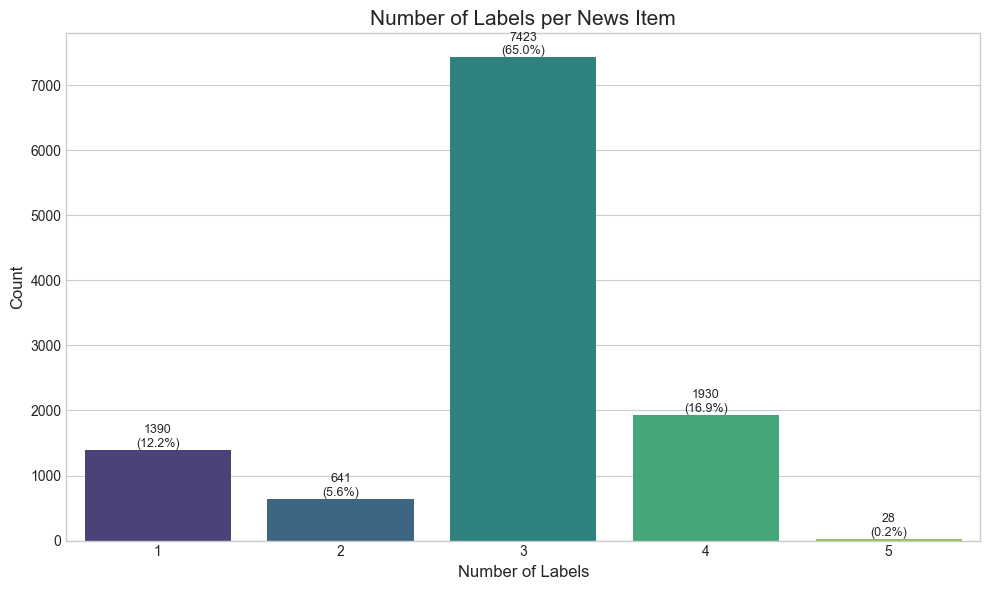

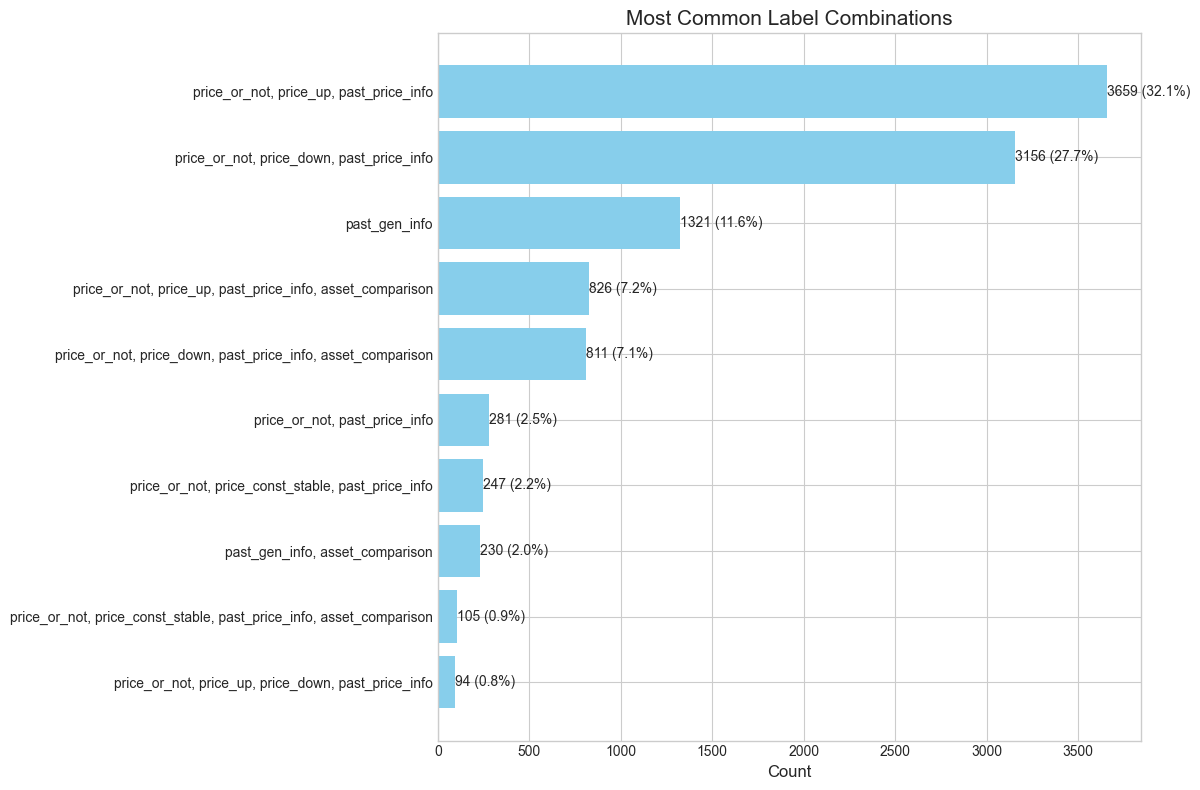

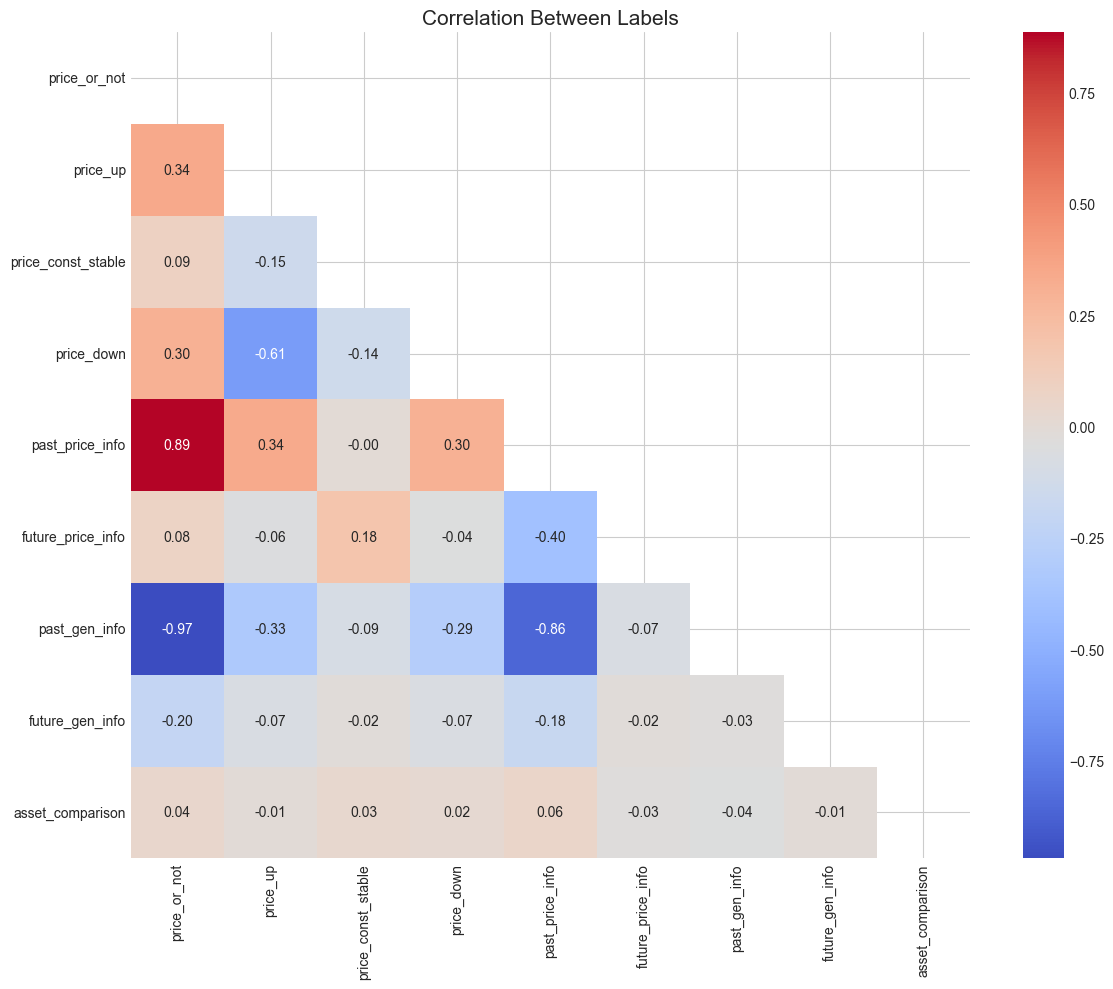

In [21]:
# Count the number of labels per news item
df['label_count'] = df[label_columns].sum(axis=1)

# Plot the distribution of label counts
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label_count', data=df, palette='viridis')
plt.title('Number of Labels per News Item', fontsize=15)
plt.xlabel('Number of Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count and percentage labels
total = len(df)
for i, p in enumerate(ax.patches):
    count = p.get_height()
    percentage = 100 * count / total
    ax.annotate(f"{int(count)}\n({percentage:.1f}%)", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Analyze most common label combinations
# Get all combinations for each row
label_combinations = []
for _, row in df[label_columns].iterrows():
    active_labels = [col for col, val in row.items() if val == 1]
    label_combinations.append(tuple(active_labels))

# Count the most common combinations
common_combinations = Counter(label_combinations).most_common(10)

# Display the most common label combinations
plt.figure(figsize=(12, 8))
combo_df = pd.DataFrame(common_combinations, columns=['Combination', 'Count'])
combo_df['Percentage'] = combo_df['Count'] / len(df) * 100
combo_df['Labels'] = combo_df['Combination'].apply(lambda x: ', '.join(x) if x else 'No labels')

# Create horizontal bar chart
bars = plt.barh(combo_df['Labels'], combo_df['Count'], color='skyblue')
plt.xlabel('Count', fontsize=12)
plt.title('Most Common Label Combinations', fontsize=15)
plt.gca().invert_yaxis()  # Invert axis to have highest frequency at the top

# Add frequency values at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
              f'{width} ({width/len(df)*100:.1f}%)', ha='left', va='center')

plt.tight_layout()
plt.show()

# Create correlation heatmap to see label relationships
plt.figure(figsize=(12, 10))
corr = df[label_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
plt.title('Correlation Between Labels', fontsize=15)
plt.tight_layout()
plt.show()


### Token Count Analysis

Token Count Statistics:


,Input Text Tokens,Input + Prompt Tokens,Output Tokens,Total Sequence Tokens
count,1000.000000,1000.000000,1000.0,1000.000000
mean,13.885000,709.769000,71.0,780.769000
std,4.988453,4.935382,0.0,4.935382
min,5.000000,701.000000,71.0,772.000000
25%,10.000000,706.000000,71.0,777.000000
50%,13.000000,709.000000,71.0,780.000000
75%,17.000000,712.000000,71.0,783.000000
max,35.000000,731.000000,71.0,802.000000


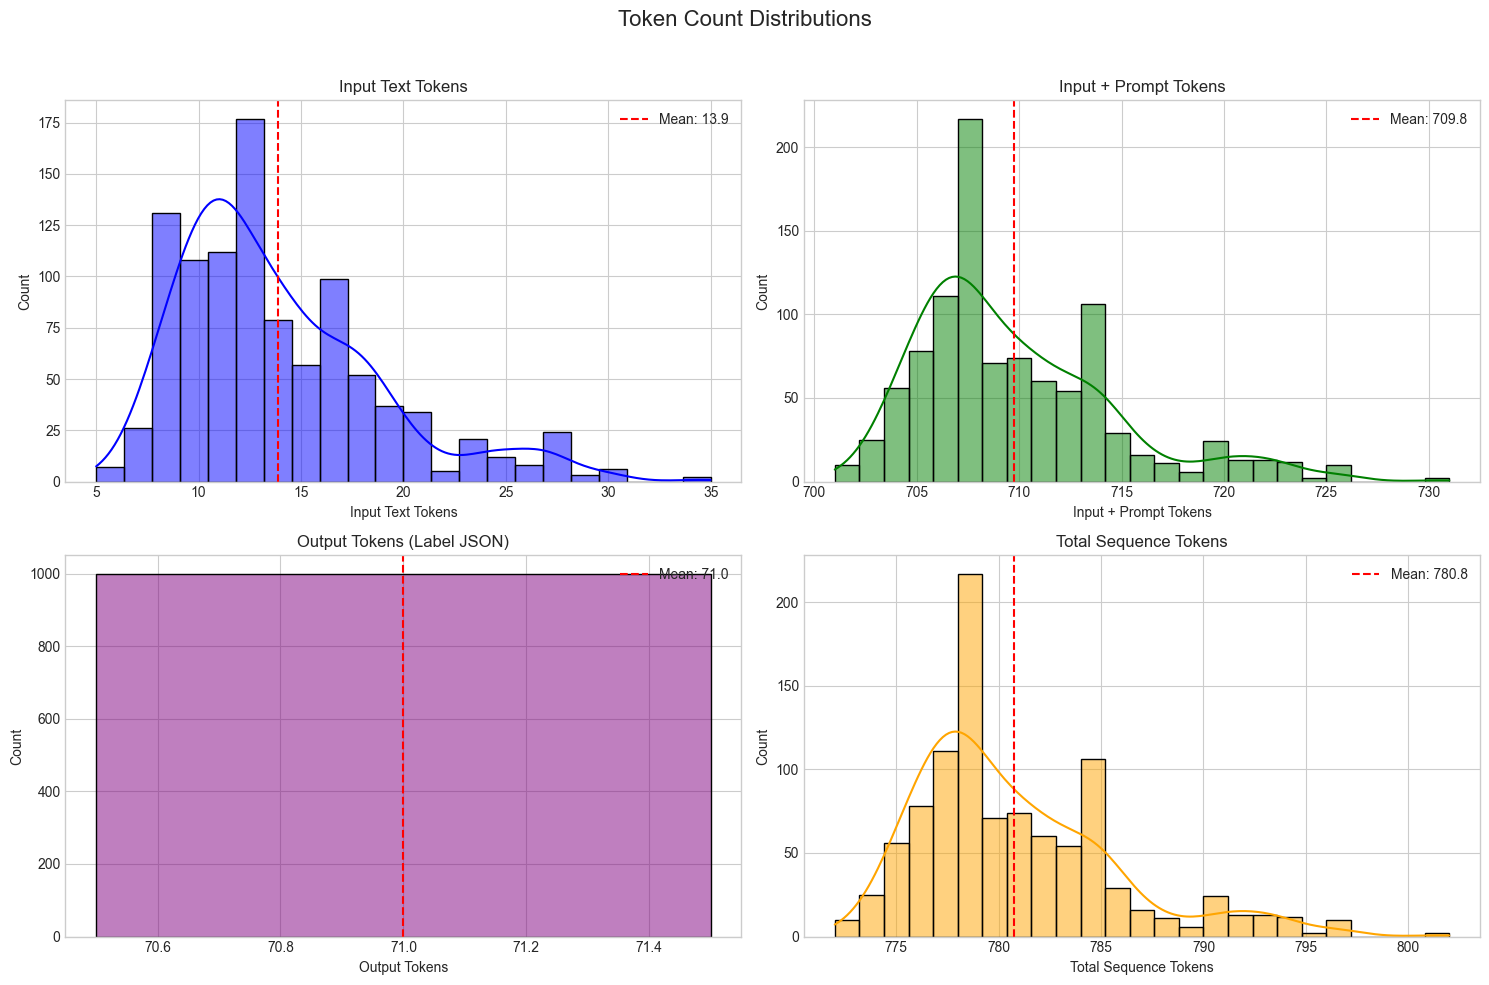

/var/folders/4v/mg6gp3rx0yj803ddxqcd01bc0000gn/T/ipykernel_68896/2025910693.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='variable', y='value', data=token_df_melt, palette='viridis')


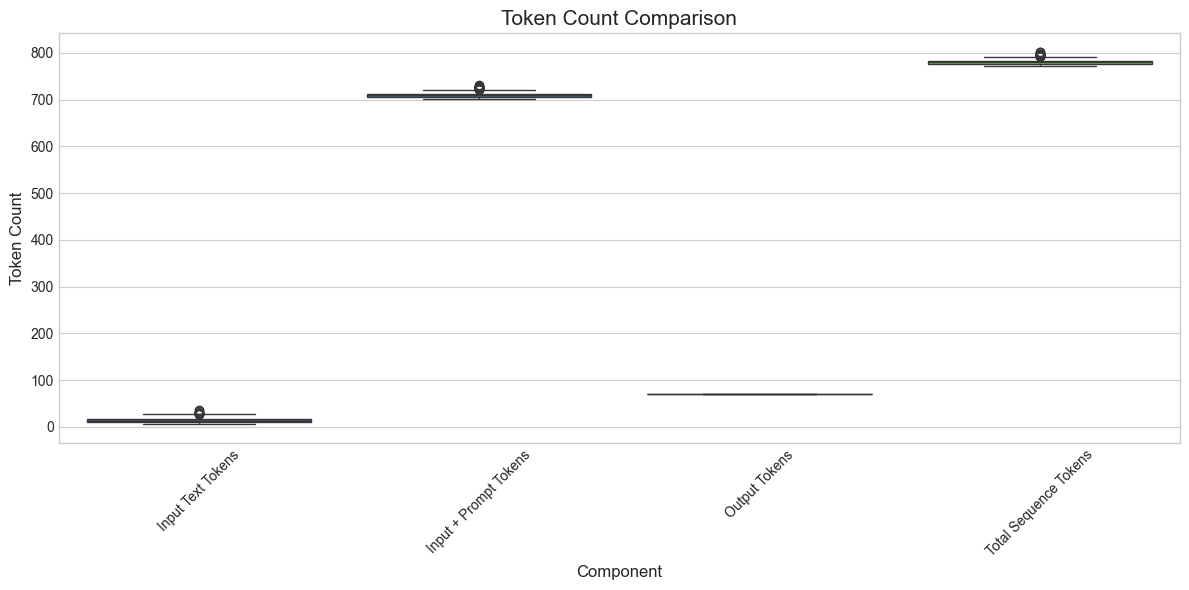


Number of examples exceeding 2048 token context window: 0


In [22]:
# Load the tokenizer (using the same one we'll use for our models)
model_name = "meta-llama/Llama-3.2-1B-Instruct"  # Change this to match your model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Initialize lists to store token counts
input_token_counts = []
prompt_token_counts = []
output_token_counts = []
total_token_counts = []

# Sample size (use all if dataset is small, otherwise limit to a reasonable number)
sample_size = min(len(df), 1000)
sample_indices = np.random.choice(len(df), sample_size, replace=False)

# Calculate token counts for each example
for idx in sample_indices:
    # Original input text
    input_text = df.iloc[idx]['News']
    input_tokens = tokenizer.encode(input_text)
    input_token_counts.append(len(input_tokens))
    
    # Input text + prompt
    prompt_text = get_gold_classification_prompt(input_text)
    prompt_tokens = tokenizer.encode(prompt_text)
    prompt_token_counts.append(len(prompt_tokens))
    
    # Output text (JSON of labels)
    # Create a dictionary from the binary labels
    output_dict = {col: int(df.iloc[idx][col]) for col in label_columns}
    output_text = str(output_dict)
    output_tokens = tokenizer.encode(output_text)
    output_token_counts.append(len(output_tokens))
    
    # Total sequence length
    total_tokens = len(prompt_tokens) + len(output_tokens)
    total_token_counts.append(total_tokens)

# Create a DataFrame for the token counts
token_df = pd.DataFrame({
    'Input Text Tokens': input_token_counts,
    'Input + Prompt Tokens': prompt_token_counts,
    'Output Tokens': output_token_counts,
    'Total Sequence Tokens': total_token_counts
})

# Display token count statistics
print("Token Count Statistics:")
display(token_df.describe())

# Create visualizations for token counts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Token Count Distributions', fontsize=16)

# Input text tokens
sns.histplot(token_df['Input Text Tokens'], kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Input Text Tokens')
axes[0, 0].axvline(token_df['Input Text Tokens'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {token_df["Input Text Tokens"].mean():.1f}')
axes[0, 0].legend()

# Input + Prompt tokens
sns.histplot(token_df['Input + Prompt Tokens'], kde=True, ax=axes[0, 1], color='green')
axes[0, 1].set_title('Input + Prompt Tokens')
axes[0, 1].axvline(token_df['Input + Prompt Tokens'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {token_df["Input + Prompt Tokens"].mean():.1f}')
axes[0, 1].legend()

# Output tokens
sns.histplot(token_df['Output Tokens'], kde=True, ax=axes[1, 0], color='purple')
axes[1, 0].set_title('Output Tokens (Label JSON)')
axes[1, 0].axvline(token_df['Output Tokens'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {token_df["Output Tokens"].mean():.1f}')
axes[1, 0].legend()

# Total sequence tokens
sns.histplot(token_df['Total Sequence Tokens'], kde=True, ax=axes[1, 1], color='orange')
axes[1, 1].set_title('Total Sequence Tokens')
axes[1, 1].axvline(token_df['Total Sequence Tokens'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {token_df["Total Sequence Tokens"].mean():.1f}')
axes[1, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Create a boxplot for token count comparison
plt.figure(figsize=(12, 6))
token_df_melt = pd.melt(token_df)
sns.boxplot(x='variable', y='value', data=token_df_melt, palette='viridis')
plt.title('Token Count Comparison', fontsize=15)
plt.xlabel('Component', fontsize=12)
plt.ylabel('Token Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check if any examples exceed a common context window size (e.g., 2048 tokens)
context_window = 2048
exceeding = token_df[token_df['Total Sequence Tokens'] > context_window]
print(f"\nNumber of examples exceeding {context_window} token context window: {len(exceeding)}")
if len(exceeding) > 0:
    print("Examples with longest token counts:")
    display(exceeding.sort_values('Total Sequence Tokens', ascending=False).head())